Init

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transforms = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transforms)
device = torch.device("cuda" if torch.cuda.is_available() else "")
print(device)

cuda


Load Data

In [76]:
batch_size = 32
train_loader = DataLoader(dataset=mnist_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
train_data_iter = iter(train_loader)
images = train_data_iter.__next__()
num_sampler = 25
sample_images = [images[0][i,0] for i in range(num_sampler)]
sample_image = sample_images[0]
image_size = sample_image.size()
x_dim = image_size[0] * image_size[1]
print(x_dim)

784


VAE Implementation

In [80]:
import torch.nn as nn
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
import time 
currentTime = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time()))
writer = SummaryWriter('./log/{currentTime}'.format(currentTime = currentTime))

class VAE(nn.Module):
    
    def __init__(self, input_dim:int = 28 * 28, hidden_dim:int = 400, latent_dim:int = 200, device:str = 'cuda'):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # encoder产生z
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim,latent_dim),
            nn.LeakyReLU(0.2),
        )
        # 然后产生p(z|x)的均值和方差
        # 图像是二维灰度图，所以方差和均值dim = 2
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.log_var_layer = nn.Linear(latent_dim, 2)
        
        # 均值和方差与z的维度一致
        # self.mean_layer = nn.Linear(latent_dim, latent_dim)
        # self.log_var_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder根据p(x|z)产生新的采样
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self,x):
        return self.decoder(x)
    
    def mean_log_var(self, x):
        mean, log_var = self.mean_layer(x), self.log_var_layer(x)
        return mean, log_var
    
    def reparameteriztion(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z
    
    def forward(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_log_var(x)
        z = self.reparameteriztion(mean, log_var)
        x_hat = self.decode(z)
        return x_hat,mean,log_var

def vae_loss_function(x, x_hat, mean, log_var):
    # 因为这个数据集的图形都是0/1，所以用交叉熵做Loss了
    reproductive_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # reproductive_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='mean')
    # reproductive_loss = nn.MSELoss(x_hat,x,reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproductive_loss + kld

def vae_train(model,optimizer,epochs,device):
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ',epoch)
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(batch_size, x_dim).to(device)
            x_hat,mean,log_var = model(data)
            loss = vae_loss_function(data, x_hat, mean, log_var)
            epoch_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        writer.add_scalar('vae_loss/train', epoch_loss, epoch)
        print(epoch_loss)

    writer.close()


class CVAE(nn.Module):
    def __init__(self, class_dim:int = 10, input_dim: int = 28 * 28, hidden_dim: int = 400, latent_dim: int = 200, device: str = 'cuda'):
        super(CVAE, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.class_dim = class_dim
        
        # embedding class
        self.label_embedding = nn.Embedding(class_dim, latent_dim)
        
        # encoder产生z
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2),
        )
        
        # 然后产生p(z|x, y)的均值和方差
        # 图像是二维灰度图，所以方差和均值dim = 2
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.log_var_layer = nn.Linear(latent_dim, 2)
        
        self.y_mean_layer = nn.Linear(latent_dim, 2)
        self.y_log_var_layer = nn.Linear(latent_dim, 2)
        
        # 均值和方差与z的维度一致
        # self.mean_layer = nn.Linear(latent_dim, latent_dim)
        # self.log_var_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder根据p(x|z, y)产生新的采样
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )   

    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        return self.decoder(x)
    
    def mean_log_var(self, x, y):
        mean, log_var = self.mean_layer(x), self.log_var_layer(x)
        y_mean, y_log_var = self.y_mean_layer(y), self.y_log_var_layer(y)
        return mean, log_var, y_mean, y_log_var
    
    def reparameteriztion(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def forward(self, x, y):
        x = self.encode(x)
        y = self.label_embedding(y)
        mean, log_var = self.mean_log_var(x, y)
        z = self.reparameteriztion(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

def cvae_loss_function(x, x_hat, mean, log_var):
    # 因为这个数据集的图形都是0/1，所以用交叉熵做Loss了
    reproductive_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproductive_loss + kld

def cvae_train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch)
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(batch_size, x_dim).to(device)
            # target = target.type(torch.float32)
            target = target.view(batch_size, 1).to(device)
            x_hat, mean, log_var = model(data, target)
            loss = cvae_loss_function(data, x_hat, mean, log_var)
            epoch_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        writer.add_scalar('cvae_loss/train', epoch_loss, epoch)
        print(epoch_loss)

    writer.close()

# cvae train
cvae_model = CVAE().to(device)
optimizer = Adam(cvae_model.parameters(), lr=1e-3)
cvae_train(cvae_model, optimizer, epochs=100, device=device)

# # vae train
# vae_model = VAE().to(device)
# optimizer = Adam(vae_model.parameters(), lr = 1e-3)
# vae_train(vae_model, optimizer, epochs=100, device=device)

Epoch:  0


TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


checkpoint

In [30]:
checkpoints_path = './checkpoints/'
checkpoint_name = f'{checkpoints_path}/vae_{currentTime}.pt'
# torch.save(vae_model.state_dict(), checkpoint_name)

checkpoint_name = f'{checkpoints_path}/cvae_{currentTime}.pt'
torch.save(cvae_model.state_dict(), checkpoint_name)

generate

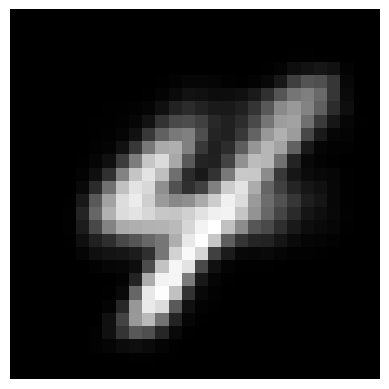

In [75]:
# vae_model_path = './checkpoints/vae_2024-03-17-19_14_38.pt'
# vae_model = VAE().to(device)
# vae_model.load_state_dict(torch.load(vae_model_path))
# vae_model.eval()

# cvae_model_path = './checkpoints/cvae_2024-03-17-19_14_38.pt'
# cvae_model = CVAE().to(device)
# cvae_model.load_state_dict(torch.load(cvae_model_path))
# cvae_model.eval()

def vae_generate_single_digit(mean, var):
    with torch.no_grad():
        z_sample = torch.tensor([[mean, var]],dtype=torch.float).to(device)
        x_decoded = vae_model.decode(z_sample)
        digit = x_decoded.detach().cpu().reshape(28, 28)
        plt.imshow(digit, cmap='grey')
        plt.axis('off')
        plt.show()

def cvae_generate_single_digit(y):
    with torch.no_grad():
        z = torch.randn(1,2, device = 'cuda')
        z = cvae_model.condition_on_label(z, y)
        x_decoded = cvae_model.decode(z)
        digit = x_decoded.detach().cpu().reshape(28, 28)
        plt.imshow(digit, cmap='grey')
        plt.axis('off')
        plt.show()
    
def plot_latent_space(model, scale=1, n=25, digit_size=28, fig_size=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))
    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(fig_size, fig_size))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


cvae_generate_single_digit(torch.tensor([9],device='cuda',dtype=torch.float32))
# plot_latent_space(vae_model)
